# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


## Libraries

In [281]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [282]:
tf.__version__

'2.10.0'

## Data Exploration

Creating CSV for the dataset

In [283]:
# csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\dataset.csv'
# headers = ['Image', 'Label']

In [284]:
# with open(csv_file_path, 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(headers)

In [285]:
# supported_extensions = ['.jpg', '.jpeg']
# 
# for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset'):
#     for file in files:
#         if any(file.lower().endswith(ext) for ext in supported_extensions):
#             image_path = os.path.join(root, file)
#             label = os.path.basename(root)
#             with open(csv_file_path, 'a', newline='') as csv_file:
#                 writer = csv.writer(csv_file)
#                 writer.writerow([file, label])

Load the dataset CSV file

In [286]:
dataset_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\dataset.csv')
dataset_df

,Image,Label
0,mixed - 10 - cataract (1).jpg,Cataract
1,mixed - 10 - cataract (10).jpg,Cataract
2,mixed - 10 - cataract (100).jpg,Cataract
3,mixed - 10 - cataract (1000).jpg,Cataract
4,mixed - 10 - cataract (1001).jpg,Cataract
...,...,...
4307,mixed - 10 - normal (995).jpg,Normal
4308,mixed - 10 - normal (996).jpg,Normal
4309,mixed - 10 - normal (997).jpg,Normal
4310,mixed - 10 - normal (998).jpg,Normal


In [287]:
print('Dataset shape:', dataset_df.shape)
print('Dataset axes:', dataset_df.axes)

Dataset shape: (4312, 2)
Dataset axes: [RangeIndex(start=0, stop=4312, step=1), Index(['Image', 'Label'], dtype='object')]


In [288]:
print('The Labels are:', dataset_df['Label'].unique())

The Labels are: ['Cataract' 'Diabetic Retinopathy' 'Glaucoma' 'Normal']


In [289]:
print(dataset_df.groupby('Label')['Image'].nunique())

print('\nType:', type(dataset_df.groupby('Label')['Image'].nunique()))

label_count = dataset_df.groupby('Label')['Image'].nunique()
label_count = label_count.to_numpy()
print('\nLabel count:', label_count)

Label
Cataract                1038
Diabetic Retinopathy    1098
Glaucoma                1105
Normal                  1071
Name: Image, dtype: int64

Type: <class 'pandas.core.series.Series'>

Label count: [1038 1098 1105 1071]


In [290]:
dataset_df.iloc[[1038]]['Image']

1038    mixed - 10 -dr (1).jpeg
Name: Image, dtype: object

[Text(0, 0, '1038'),
 Text(0, 0, '1098'),
 Text(0, 0, '1105'),
 Text(0, 0, '1071')]

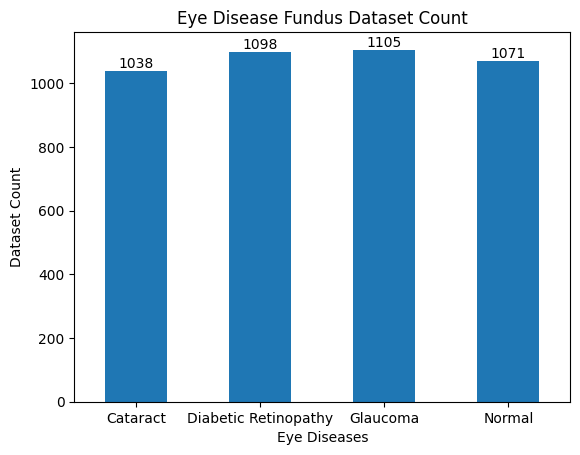

In [291]:
# Plotting dataset count in each class

dataset_df_chart = dataset_df.groupby('Label')['Image'].nunique().plot(kind='bar', 
                                                                       title='Eye Disease Fundus Dataset Count',
                                                                       xlabel='Eye Diseases',
                                                                       ylabel='Dataset Count',
                                                                       rot=0)

dataset_df_chart.bar_label(dataset_df_chart.containers[0])

## Data loading & preprocessing

### Data loading

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [292]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

os.chdir('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Splitted)')
dataset_dir = os.getcwd()
print('Dataset directory:', dataset_dir)

Dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)


In [293]:
# Dataset path

train_url = dataset_dir + '\\train'
val_url = dataset_dir + '\\val'
test_url = dataset_dir + '\\test'

train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('train_url\t:', train_url)
print('val_url\t\t:', val_url)
print('test_url\t:', test_url)

print('\ntrain_dir\t:', train_dir)
print('val_dir\t\t:', val_dir)
print('test_dir\t:', test_dir)

train_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\train
val_url		: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\val
test_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\test

train_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\train
val_dir		: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\val
test_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (Splitted)\test


In [294]:
# Image count

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images:', train_count)
print('Total validation set images:', val_count)
print('Total test set images:', test_count)

Total training set images: 3016
Total validation set images: 644
Total test set images: 652


Turn the splitted dataset into dataframe

In [295]:
data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

Train information
---------------
Label names		: ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
Label counts		: [726, 768, 773, 749]
Total image count	: 3016 

Val information
---------------
Label names		: ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
Label counts		: [155, 164, 165, 160]
Total image count	: 644 

Test information
---------------
Label names		: ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
Label counts		: [157, 166, 167, 162]
Total image count	: 652 



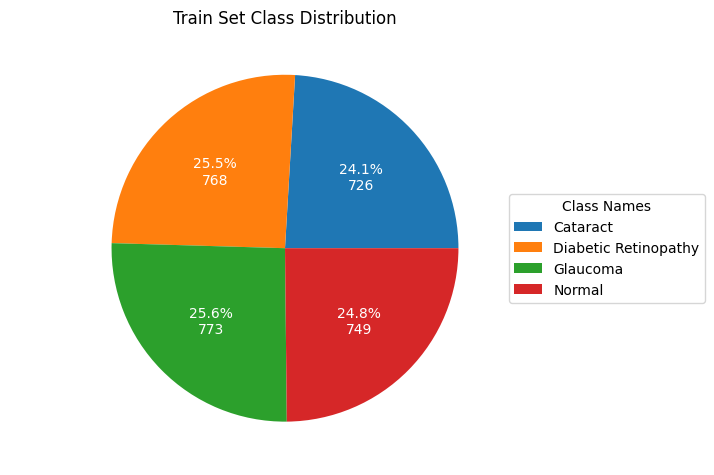

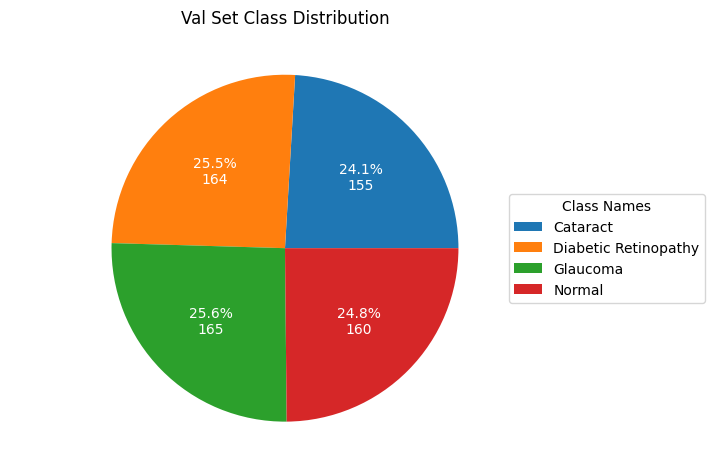

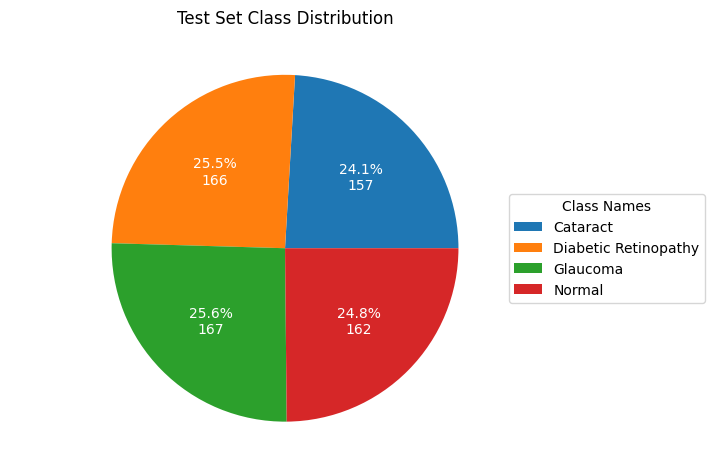

In [296]:
for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d}"

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                        labels=class_names, 
                                        autopct=lambda pct: func(pct, num_each), 
                                        textprops=dict(color='w'))
    ax.legend(wedges, 
                class_names,
                title='Class Names',
                loc='center left',
                bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'{phase.capitalize()} Set Class Distribution')
    plt.tight_layout()

In [297]:
# Set some parameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('\nIMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32

IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


Load the dataset using ImageDataGenerator (deprecated)

In [298]:
augmentation_params = {
    'rotation_range': 20,
    'horizontal_flip': True,
    'vertical_flip': True
}

datagen = {
    'train': ImageDataGenerator(
        # preprocessing_input=tf.keras.applications.mobilenet_v3.preprocess_input,
        # rescale=1.0 / 127.5 - 1.0,
        rescale=1/255.,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        fill_mode='constant'
    ),
    'val': ImageDataGenerator(
        # rescale=1.0 / 127.5 - 1.0,
        rescale=1/255.,
    ),
    'test': ImageDataGenerator(
        # rescale=1.0 / 127.5 - 1.0,
        rescale=1/255.,
    ),
}

In [299]:
data_sets = {
    'train': data_generator['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE),
    'val': data_generator['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE),
    'test': data_generator['test'].flow_from_directory(
        test_dir, 
        shuffle=True, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE)
}

Found 3016 images belonging to 4 classes.
Found 644 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


In [300]:
for i, (images, labels) in enumerate(data_sets['train']):
    print('First batch labels:', labels)
    print('Labels shape:', labels.shape)
    print('Images shape:', images.shape)
    break

First batch labels: [0. 3. 0. 3. 0. 1. 0. 1. 0. 2. 2. 0. 1. 1. 0. 1. 1. 1. 2. 0. 2. 3. 0. 1.
 3. 0. 1. 3. 1. 0. 2. 2.]
Labels shape: (32,)
Images shape: (32, 100, 100, 3)


Show the first nine images and labels from the training set:

In [318]:
def show_images(GRID=[3,3], model=None, size=(8,8), data=data_sets['train']):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    i = 1
    plt.figure(figsize=size)

    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        i+=1
        
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


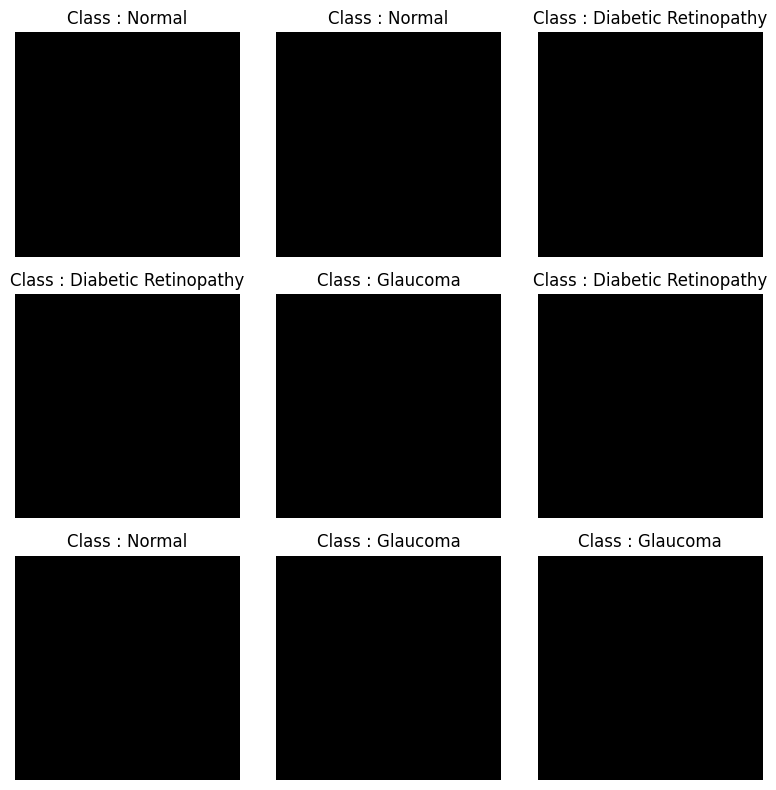

In [319]:
show_images()

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [301]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [302]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [303]:
# AUTOTUNE = tf.data.AUTOTUNE
# 
# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [304]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomFlip('vertical'),
#   tf.keras.layers.RandomRotation(0.2, fill_mode='constant'),
#   # tf.keras.layers.RandomBrightness(0.2),
#   # tf.keras.layers.RandomContrast(0.2),
# ])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

In [305]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [306]:
# preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [307]:
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# rescale = tf.keras.layers.Rescaling(1./255)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [308]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [309]:
image_batch, label_batch = next(iter(data_sets['train']))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 576)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [310]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 rescaling_2
2 Conv
3 Conv/BatchNorm
4 tf.__operators__.add_54
5 re_lu_64
6 tf.math.multiply_54
7 multiply_36
8 expanded_conv/depthwise/pad
9 expanded_conv/depthwise
10 expanded_conv/depthwise/BatchNorm
11 re_lu_65
12 expanded_conv/squeeze_excite/AvgPool
13 expanded_conv/squeeze_excite/Conv
14 expanded_conv/squeeze_excite/Relu
15 expanded_conv/squeeze_excite/Conv_1
16 tf.__operators__.add_55
17 re_lu_66
18 tf.math.multiply_55
19 expanded_conv/squeeze_excite/Mul
20 expanded_conv/project
21 expanded_conv/project/BatchNorm
22 expanded_conv_1/expand
23 expanded_conv_1/expand/BatchNorm
24 re_lu_67
25 expanded_conv_1/depthwise/pad
26 expanded_conv_1/depthwise
27 expanded_conv_1/depthwise/BatchNorm
28 re_lu_68
29 expanded_conv_1/project
30 expanded_conv_1/project/BatchNorm
31 expanded_conv_2/expand
32 expanded_conv_2/expand/BatchNorm
33 re_lu_69
34 expanded_conv_2/depthwise
35 expanded_conv_2/depthwise/BatchNorm
36 re_lu_70
37 expanded_conv_2/project
38 expanded_conv_2/project/Batc

In [311]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [312]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 100, 100, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 50, 50, 16)   432         ['rescaling_2[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 50, 50, 16)  64          ['Conv[0][0]']    

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [313]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [314]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [323]:
# inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model.output
# x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [324]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [325]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 100, 100, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 50, 50, 16)   432         ['rescaling_2[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 50, 50, 16)  64          ['Conv[0][0]']             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [326]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [328]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(data_sets['val'])

21/21 [==============================] - 12s 465ms/step - loss: 1.4178 - accuracy: 0.2888


In [329]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.42
initial accuracy: 0.29


In [331]:
history = model.fit(data_sets['train'],
                    epochs=initial_epochs,
                    validation_data=data_sets['val'])

Epoch 1/10
95/95 [==============================] - 60s 590ms/step - loss: 1.4174 - accuracy: 0.3219 - val_loss: 1.2252 - val_accuracy: 0.4363
Epoch 2/10
95/95 [==============================] - 40s 424ms/step - loss: 1.2448 - accuracy: 0.4390 - val_loss: 1.0840 - val_accuracy: 0.5792
Epoch 3/10
95/95 [==============================] - 40s 427ms/step - loss: 1.1476 - accuracy: 0.5063 - val_loss: 0.9895 - val_accuracy: 0.6398
Epoch 4/10
95/95 [==============================] - 40s 423ms/step - loss: 1.0395 - accuracy: 0.5733 - val_loss: 0.9113 - val_accuracy: 0.6817
Epoch 5/10
95/95 [==============================] - 41s 430ms/step - loss: 0.9685 - accuracy: 0.6170 - val_loss: 0.8575 - val_accuracy: 0.6848
Epoch 6/10
95/95 [==============================] - 42s 446ms/step - loss: 0.8952 - accuracy: 0.6681 - val_loss: 0.8057 - val_accuracy: 0.7158
Epoch 7/10
95/95 [==============================] - 43s 448ms/step - loss: 0.8574 - accuracy: 0.6800 - val_loss: 0.7699 - val_accuracy: 0.7220

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

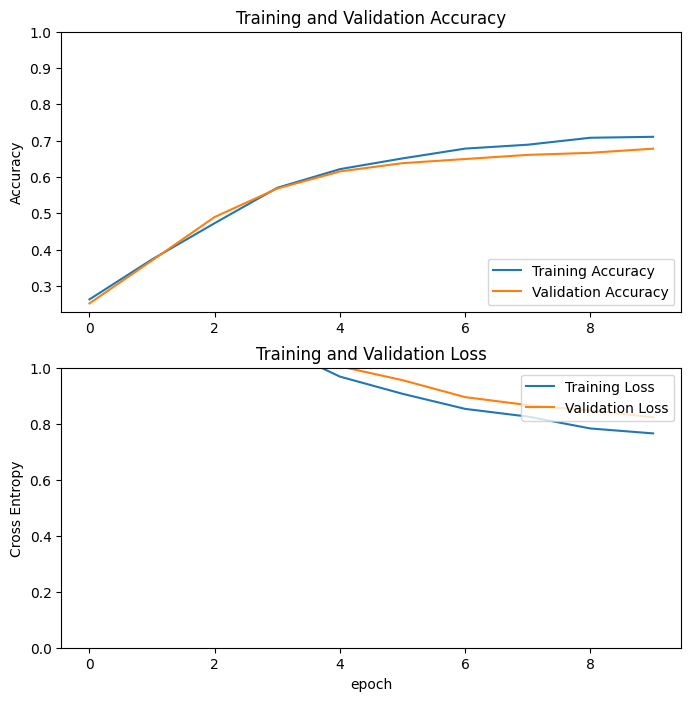

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  229


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2308

In [ ]:
len(model.trainable_variables)

75

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
108/108 [==============================] - 84s 631ms/step - loss: 0.6672 - accuracy: 0.7412 - val_loss: 0.6882 - val_accuracy: 0.7222
Epoch 11/20
108/108 [==============================] - 66s 590ms/step - loss: 0.5771 - accuracy: 0.7762 - val_loss: 0.6252 - val_accuracy: 0.7479
Epoch 12/20
108/108 [==============================] - 66s 587ms/step - loss: 0.5405 - accuracy: 0.7945 - val_loss: 0.5991 - val_accuracy: 0.7464
Epoch 13/20
108/108 [==============================] - 68s 619ms/step - loss: 0.5012 - accuracy: 0.8107 - val_loss: 0.5461 - val_accuracy: 0.7778
Epoch 14/20
108/108 [==============================] - 61s 549ms/step - loss: 0.4689 - accuracy: 0.8159 - val_loss: 0.5171 - val_accuracy: 0.7863
Epoch 15/20
108/108 [==============================] - 65s 585ms/step - loss: 0.4396 - accuracy: 0.8342 - val_loss: 0.5002 - val_accuracy: 0.7920
Epoch 16/20
108/108 [==============================] - 64s 569ms/step - loss: 0.4124 - accuracy: 0.8528 - val_loss: 0.4956 -

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

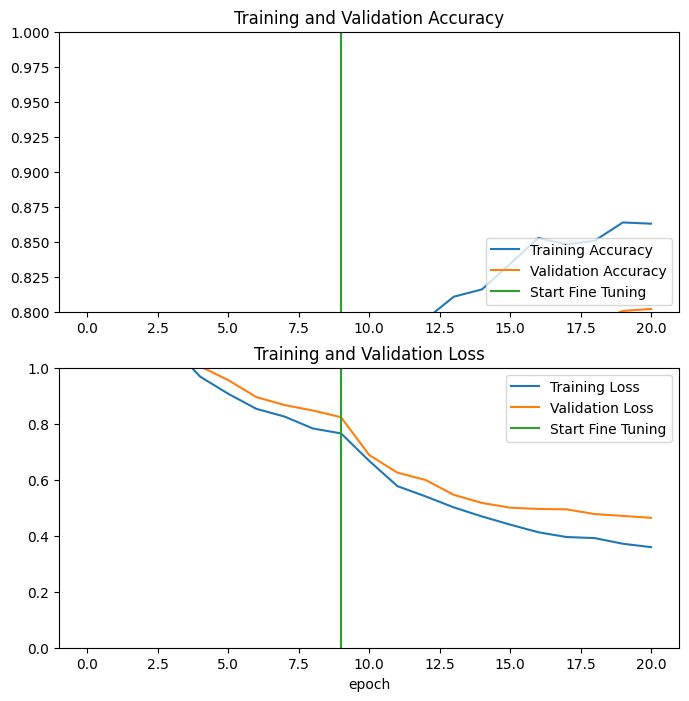

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 3s 201ms/step - loss: 0.3859 - accuracy: 0.8125
Test accuracy : 0.8125


And now you are all set to use this model to predict if your pet is a cat or dog.

1/1 [==============================] - 2s 2s/step
Predictions:
 ['Glaucoma' 'Normal' 'Normal' 'Cataract' 'Cataract' 'Diabetic Retinopathy'
 'Normal' 'Normal' 'Glaucoma' 'Cataract' 'Glaucoma' 'Normal'
 'Diabetic Retinopathy' 'Cataract' 'Diabetic Retinopathy'
 'Diabetic Retinopathy' 'Normal' 'Normal' 'Glaucoma' 'Cataract' 'Normal'
 'Normal' 'Diabetic Retinopathy' 'Normal' 'Glaucoma' 'Glaucoma'
 'Diabetic Retinopathy' 'Normal' 'Glaucoma' 'Normal' 'Glaucoma'
 'Diabetic Retinopathy']
Labels:
 [2 1 1 0 3 1 3 3 0 0 2 0 1 0 1 1 3 3 2 0 3 3 1 2 2 1 1 3 2 3 2 1]


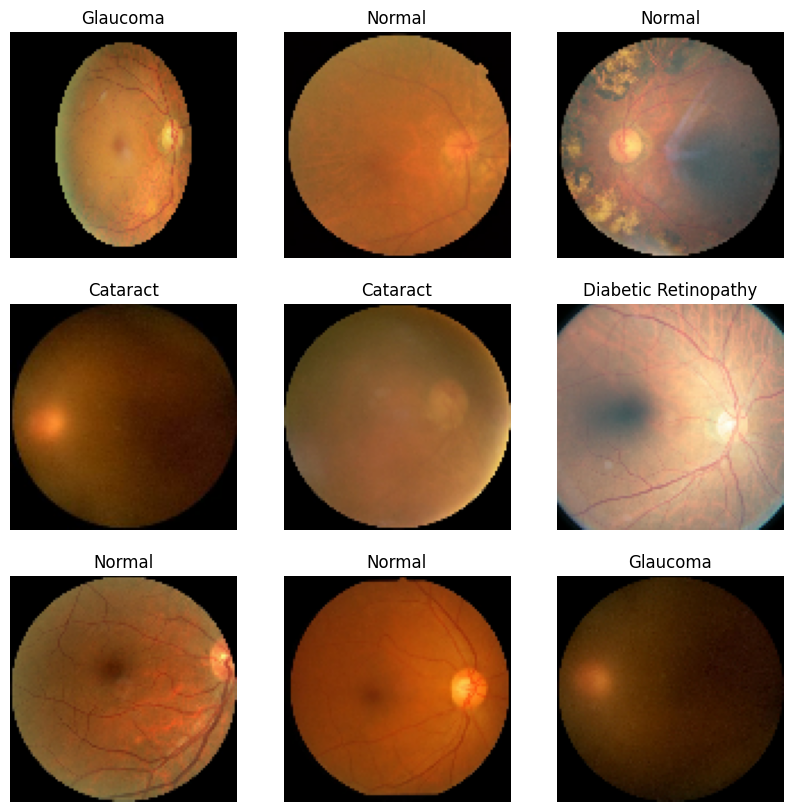

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=1)
class_names = np.array(class_names)
predicted_label_batch = class_names[predicted_id]

# print('Predictions:\n', predictions.numpy())
print('Predictions:\n', predicted_label_batch)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  # plt.title(class_names[predictions[i]])
  plt.title(predicted_label_batch[i])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
